# Board Game Graphs

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap
import seaborn as sns

import sqlite3
import csv
import time
import requests
from bs4 import BeautifulSoup

from sklearn import metrics
from sklearn.manifold import TSNE
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, ward
import networkx as nx
import hdbscan


%matplotlib inline

In [2]:
sns.set_style('darkgrid')

## Exploritory Data Analysis

This project will combine historic data on game mechanics with recently scraped data on category as well as user ratings. We will first load up the historic data provided on Kaggle (https://www.kaggle.com/gabrio/board-games-dataset). We will clean this data before scraping the website https://boardgamegeek.com/ for more up to date data.

In [3]:
# Connect to the SQL database and load all of the raw data into a pandas dataframe

conn = sqlite3.connect('../database.sqlite 2')

df_raw = pd.read_sql_query('SELECT * FROM BoardGames', conn)

conn.close()

In [4]:
# As we will be dealing with fairly wide dataframes we'll want to ensure that the whole thing is visable
# To get a better understanding of our data we sort by average stats in the hope of getting well known recognisabe games
# However we quickly see that sorting by 'stats.average' places games with few high votes much higher than more famous games

pd.set_option('display.max_columns', 999)
df_raw.sort_values(by = ['stats.average'], ascending=False).head()

,row_names,game.id,game.type,details.description,details.image,details.maxplayers,details.maxplaytime,details.minage,details.minplayers,details.minplaytime,details.name,details.playingtime,details.thumbnail,details.yearpublished,attributes.boardgameartist,attributes.boardgamecategory,attributes.boardgamecompilation,attributes.boardgamedesigner,attributes.boardgameexpansion,attributes.boardgamefamily,attributes.boardgameimplementation,attributes.boardgameintegration,attributes.boardgamemechanic,attributes.boardgamepublisher,attributes.total,stats.average,stats.averageweight,stats.bayesaverage,stats.family.abstracts.bayesaverage,stats.family.abstracts.pos,stats.family.cgs.bayesaverage,stats.family.cgs.pos,stats.family.childrensgames.bayesaverage,stats.family.childrensgames.pos,stats.family.familygames.bayesaverage,stats.family.familygames.pos,stats.family.partygames.bayesaverage,stats.family.partygames.pos,stats.family.strategygames.bayesaverage,stats.family.strategygames.pos,stats.family.thematic.bayesaverage,stats.family.thematic.pos,stats.family.wargames.bayesaverage,stats.family.wargames.pos,stats.median,stats.numcomments,stats.numweights,stats.owned,stats.stddev,stats.subtype.boardgame.bayesaverage,stats.subtype.boardgame.pos,stats.trading,stats.usersrated,stats.wanting,stats.wishing,polls.language_dependence,polls.suggested_numplayers.1,polls.suggested_numplayers.10,polls.suggested_numplayers.2,polls.suggested_numplayers.3,polls.suggested_numplayers.4,polls.suggested_numplayers.5,polls.suggested_numplayers.6,polls.suggested_numplayers.7,polls.suggested_numplayers.8,polls.suggested_numplayers.9,polls.suggested_numplayers.Over,polls.suggested_playerage,attributes.t.links.concat.2....,stats.family.amiga.bayesaverage,stats.family.amiga.pos,stats.family.arcade.bayesaverage,stats.family.arcade.pos,stats.family.atarist.bayesaverage,stats.family.atarist.pos,stats.family.commodore64.bayesaverage,stats.family.commodore64.pos,stats.subtype.rpgitem.bayesaverage,stats.subtype.rpgitem.pos,stats.subtype.videogame.bayesaverage,stats.subtype.videogame.pos
88590,88591,213296,boardgame,"Meu Jardim (My Garden, in Portuguese) is a til...",//cf.geekdo-images.com/images/pic3291166.jpg,4.0,30.0,4.0,1.0,10.0,Meu Jardim,30.0,//cf.geekdo-images.com/images/pic3291166_t.jpg,2016.0,Luiza Sequeira,"Children's Game,Puzzle",None,Rafael Arrivabene,None,None,None,None,"Pattern Recognition,Tile Placement",Ludens Spirit,5.0,10.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.0,0.0,1.0,0.0,NaN,NaN,0.0,1.0,0.0,0.0,None,None,None,None,None,None,None,None,None,None,None,None,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
85161,85162,220661,boardgame,Description from the publisher:&#10;&#10;Genso...,//cf.geekdo-images.com/images/pic3446081.jpg,2.0,30.0,0.0,2.0,30.0,Genso Suikoden Card Stories Trading Card Game,30.0,//cf.geekdo-images.com/images/pic3446081_t.jpg,2001.0,None,"Card Game,Collectible Components,Math,Video Ga...",None,None,None,CCGs (Collectible Card Games),None,None,Hand Management,Konami,4.0,10.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,1.0,0.0,NaN,NaN,0.0,1.0,0.0,0.0,None,None,None,None,None,None,None,None,None,None,None,None,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
90072,90073,219140,boardgameexpansion,"Since 1943 the ISU format, a heavy self-propel...",//cf.geekdo-images.com/images/pic3426277.jpg,2.0,0.0,0.0,2.0,0.0,"Dust Tactics: ISU-203 Heavy Assault Gun – ""Ser...",0.0,//cf.geekdo-images.com/images/pic3426277_t.jpg,0.0,Paolo Parente,"Miniatures,Science Fiction,World War II",None,Paolo Parente,"Dust 1947,Dust Tactics,Dust Tactics: Revised C...",Dust,None,None,"Action Point Allowance System,Dice Rolling,Mod...",Dust Studio,7.0,10.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,1.0,0.0,1.0,None,None,None,None,None,None,None,None,None,None,None,None,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N

In [5]:
# A quick look at our columns shows that many of variables are null,
# significant cleaning will be required

df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90400 entries, 0 to 90399
Data columns (total 81 columns):
row_names                                   90400 non-null object
game.id                                     90400 non-null object
game.type                                   90400 non-null object
details.description                         90400 non-null object
details.image                               83508 non-null object
details.maxplayers                          90397 non-null float64
details.maxplaytime                         90397 non-null float64
details.minage                              90397 non-null float64
details.minplayers                          90397 non-null float64
details.minplaytime                         90397 non-null float64
details.name                                90400 non-null object
details.playingtime                         90397 non-null float64
details.thumbnail                           83508 non-null object
details.yearpublished      

In [6]:
# Let's have a look at some hopefully useful variables
# Who the designer is may be useful infomation in clustering our board games
# Sadly there are probably too many (and with too skewed a distribution) to use
# This is also true of other variables like artist and publisher

df_raw['attributes.boardgamedesigner'].value_counts()

(Uncredited)             18729
Lloyd Krassner             765
Reiner Knizia              493
Charles Darrow             246
Michael Schacht            205
                         ...  
Franz Konz                   1
Troy Caldwell                1
Ray Sullivan                 1
Casey Clark,Gabe Ivan        1
Nicholas C. Arellano         1
Name: attributes.boardgamedesigner, Length: 22699, dtype: int64

In [7]:
df_raw['attributes.boardgameartist'].value_counts()

(Uncredited)                      3649
Franz Vohwinkel                    285
Michael Menzel                     206
Rodger B. MacGowan                 204
John Kovalic                       189
                                  ... 
Richard Polle                        1
Olivier Frot,Franz Vohwinkel         1
Peter Sanderson                      1
David J. Coffey,David Szilagyi       1
Kei Tsukahara (つかはら けい)              1
Name: attributes.boardgameartist, Length: 14085, dtype: int64

In [8]:
df_raw['attributes.boardgamepublisher'].value_counts()

(Self-Published)            3433
(Web published)             2911
(Unknown)                   1340
Milton Bradley               877
Warp Spawn Games             871
                            ... 
4thman Games                   1
Whatsinagame                   1
The Drag Racing Game Co.       1
AAA Thought Co., Inc.          1
Modesto Gamers                 1
Name: attributes.boardgamepublisher, Length: 24516, dtype: int64

In [9]:
# Taking a look at the mechanics gives us something that may be more managable though it will take some work to transform into useful data
# We will return to this later on and turn each seperate mechanic into its own column

df_raw['attributes.boardgamemechanic'].value_counts()

Roll / Spin and Move                                                                                                      6833
Dice Rolling                                                                                                              3998
Hex-and-Counter                                                                                                           3281
Hand Management                                                                                                           1858
Set Collection                                                                                                            1648
                                                                                                                          ... 
Rock-Paper-Scissors,Voting                                                                                                   1
Deck / Pool Building,Hand Management,Partnerships,Point to Point Movement,Rock-Paper-Scissors,Set Collection,Ta

In [10]:
# As we'll be wanting to work with the game's mechanics we can safely drop any games that don't have any listed mechanics

print(f'There were {sum(df_raw["attributes.boardgamemechanic"].isna())} games with no listed mechanics')
df_raw.dropna(subset=['attributes.boardgamemechanic'], inplace=True)

There were 15237 games with no listed mechanics


In [11]:
sum(df_raw['attributes.boardgamecategory'].isna())

876

In [12]:
# Do the same to category
df_raw.dropna(subset=['attributes.boardgamecategory'], inplace=True)

In [13]:
# We are also only interested in board games rather than any expansions
# Let's take a look and see how many actual board games we have and then drop all the others

df_raw['game.type'].value_counts()

boardgame             62114
boardgameexpansion    12173
Name: game.type, dtype: int64

In [14]:
df_raw = df_raw.loc[df_raw['game.type'] != 'boardgameexpansion']

In [15]:
# Looking at what we'd be left with if we only select games that have more than 30 votes on BBG
# The least popular game (according to the somewhat fussy BBG community) is the old classic Tic-Tac-Toe
# This seems like a good cut off point and leaves us with plenty of games to play with
# Our most voted on game, Catan, has 67655 votes so this seems like a safe cut-off

df_raw.loc[df_raw['stats.usersrated'] > 30].sort_values(by='stats.bayesaverage', ascending = False)

,row_names,game.id,game.type,details.description,details.image,details.maxplayers,details.maxplaytime,details.minage,details.minplayers,details.minplaytime,details.name,details.playingtime,details.thumbnail,details.yearpublished,attributes.boardgameartist,attributes.boardgamecategory,attributes.boardgamecompilation,attributes.boardgamedesigner,attributes.boardgameexpansion,attributes.boardgamefamily,attributes.boardgameimplementation,attributes.boardgameintegration,attributes.boardgamemechanic,attributes.boardgamepublisher,attributes.total,stats.average,stats.averageweight,stats.bayesaverage,stats.family.abstracts.bayesaverage,stats.family.abstracts.pos,stats.family.cgs.bayesaverage,stats.family.cgs.pos,stats.family.childrensgames.bayesaverage,stats.family.childrensgames.pos,stats.family.familygames.bayesaverage,stats.family.familygames.pos,stats.family.partygames.bayesaverage,stats.family.partygames.pos,stats.family.strategygames.bayesaverage,stats.family.strategygames.pos,stats.family.thematic.bayesaverage,stats.family.thematic.pos,stats.family.wargames.bayesaverage,stats.family.wargames.pos,stats.median,stats.numcomments,stats.numweights,stats.owned,stats.stddev,stats.subtype.boardgame.bayesaverage,stats.subtype.boardgame.pos,stats.trading,stats.usersrated,stats.wanting,stats.wishing,polls.language_dependence,polls.suggested_numplayers.1,polls.suggested_numplayers.10,polls.suggested_numplayers.2,polls.suggested_numplayers.3,polls.suggested_numplayers.4,polls.suggested_numplayers.5,polls.suggested_numplayers.6,polls.suggested_numplayers.7,polls.suggested_numplayers.8,polls.suggested_numplayers.9,polls.suggested_numplayers.Over,polls.suggested_playerage,attributes.t.links.concat.2....,stats.family.amiga.bayesaverage,stats.family.amiga.pos,stats.family.arcade.bayesaverage,stats.family.arcade.pos,stats.family.atarist.bayesaverage,stats.family.atarist.pos,stats.family.commodore64.bayesaverage,stats.family.commodore64.pos,stats.subtype.rpgitem.bayesaverage,stats.subtype.rpgitem.pos,stats.subtype.videogame.bayesaverage,stats.subtype.videogame.pos
71064,71065,161936,boardgame,Pandemic Legacy is a co-operative campaign gam...,//cf.geekdo-images.com/images/pic2452831.png,4.0,60.0,13.0,2.0,60.0,Pandemic Legacy: Season 1,60.0,//cf.geekdo-images.com/images/pic2452831_t.png,2015.0,Chris Quilliams,"Environmental,Medical",None,"Rob Daviau,Matt Leacock",None,"Campaign Games,Legacy,Pandemic",Pandemic,None,"Action Point Allowance System,Co-operative Pla...","Z-Man Games,Asterion Press,Devir,Filosofia Édi...",7.0,8.66878,2.8026,8.48966,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.47923,1.0,8.49443,1.0,NaN,NaN,0.0,2947.0,613.0,28322.0,1.73529,8.48966,1.0,107.0,17251.0,646.0,5901.0,Extensive,NotRecommended,None,Recommended,Recommended,Best,None,None,None,None,None,NotRecommended,12,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
78529,78530,182028,boardgame,Through the Ages: A New Story of Civilization ...,//cf.geekdo-images.com/images/pic2663291.jpg,4.0,240.0,14.0,2.0,180.0,Through the Ages: A New Story of Civilization,240.0,//cf.geekdo-images.com/images/pic2663291_t.jpg,2015.0,"Jakub Politzer,Milan Vavroň","Card Game,Civilization,Economic",None,Vlaada Chvátil,None,Tableau Building,Through the Ages: A Story of Civilization,None,"Action Point Allowance System,Auction/Bidding,...","Cranio Creations,Czech Games Edition,Devir,Dic...",7.0,8.74235,4.3056,8.30554,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.40900,2.0,NaN,NaN,NaN,NaN,0.0,1058.0,373.0,9337.0,1.46808,8.30554,2.0,50.0,6888.0,1017.0,4662.0,Extensive,NotRecommended,None,Recommended,Best,Recommended,None,None,None,None,None,NotRecommended,14,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11367,11368,12333,boardgame,"&quot;Now the trumpet summons us again, not as...",//cf.geekdo-images.com/images/pic361592.jpg,2.0,180.0,13.0,2.0,180.0,Twilight Struggle,180.0,//cf.geekdo-images.com/images/pic361592_t.jpg,2005.0,"Viktor Csete,Rodger B. MacGowan,Chechu Nieto,G...","Modern Warfare,Political,

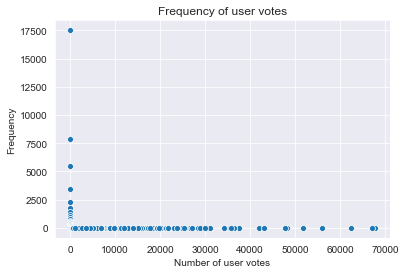

In [16]:
# Plot to check the distribution of user votes

sns.scatterplot(data = df_raw['stats.usersrated'].value_counts())
plt.title('Frequency of user votes')
plt.xlabel('Number of user votes')
plt.ylabel('Frequency')
plt.show()

In [17]:
df_raw = df_raw.loc[df_raw['stats.usersrated'] > 30]

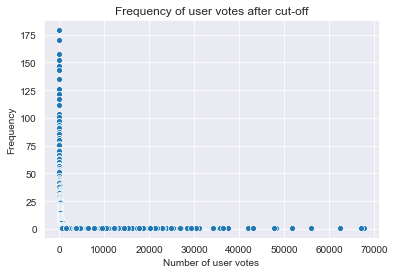

In [18]:
# That's a bit better

sns.scatterplot(data = df_raw['stats.usersrated'].value_counts())
plt.title('Frequency of user votes after cut-off')
plt.xlabel('Number of user votes')
plt.ylabel('Frequency')
plt.show()

In [19]:
# As we only care about the mechanic column in df_raw (we'll be scraping more up to date info later) our EDA of the Kaggle data is done

In [20]:
# We'll want to join on the game.id column so it better be well behaved

df_raw.rename(columns={'game.id' : 'id'}, inplace=True)

In [21]:
df_raw = df_raw.astype({'id': 'int64'});

In [22]:
df_raw['id'].dtype

dtype('int64')

In [23]:
# df_raw.to_csv('data/df_raw.csv', index=False)

In [24]:
df_raw = pd.read_csv('data/df_raw.csv')

### Scraping BGG and some more EDA

We will now scrape BGG for more data on user ratings, weights, and game category. The scraping uses the excellent code (with some small modifications) written by TheWeatherman: https://github.com/ThaWeatherman/scrapers/tree/master/boardgamegeek.

NOT NEEDED? An items.csv file was created by running `scrapy runspider spider.py -o items.csv` in the command line, this scrapes BGG for the average rating, geek rating, id, and number of votes for each game on the site. This csv is then used by Beautiful Soup to gather more indepth infomation from the site.

In [25]:
# Create a list of game ids from df_raw
# These will be used in our scraper

# ids_final = [str(x) for x in df_raw['id']]
# ids_final = list(set(ids_final))
# with open('ids_final.txt', 'w') as f:
#     f.write('\n'.join(ids_final))

In [26]:
# TheWeatherman's code with some small changes made to the scraped categories
# This will return a games_final.csv

# def get_val(tag, term):
#     try:
#         val = tag.find(term)['value'].encode('ascii', 'ignore')
#     except:
#         val = 'NaN'
#     return val


# base = 'http://www.boardgamegeek.com/xmlapi2/thing?id={}&stats=1'
# with open('ids_final.txt') as f:
#     ids = [line.strip() for line in f.readlines()]
# split = 30
# f = open('games_final.csv', 'w')
# writer = csv.writer(f)
# writer.writerow(('id','name', 'yearpublished', 'minplayers', 'maxplayers', 'playingtime', 'users_rated',
#                  'average_rating','bayes_average_rating', 'total_weights', 'average_weight'))

# for i in range(0, len(ids), split):
#     url = base.format(','.join(ids[i:i+split]))
#     print('Requesting {}'.format(url))
#     req = requests.get(url)
#     soup = BeautifulSoup(req.content, 'xml')
#     items = soup.find_all('item')
#     for item in items:
#         gid = item['id']
#         gname = get_val(item, 'name')
#         gyear = get_val(item, 'yearpublished')
#         gmin = get_val(item, 'minplayers')
#         gmax = get_val(item, 'maxplayers')
#         gplay = get_val(item, 'playingtime')
#         usersrated = get_val(item.statistics.ratings, 'usersrated')
#         avg = get_val(item.statistics.ratings, 'average')
#         bayesavg = get_val(item.statistics.ratings, 'bayesaverage')
#         numweights = get_val(item.statistics.ratings, 'numweights')
#         avgweight = get_val(item.statistics.ratings, 'averageweight')
#         # desc = item.description.text.encode('ascii', 'ignore')
#         writer.writerow((gid, gname, gyear, gmin, gmax, gplay, usersrated, avg, bayesavg, numweights, avgweight))
#     time.sleep(2)
# f.close()

In [27]:
df_scrape = pd.DataFrame(pd.read_csv('data/games_final.csv')).set_index('id')
df_scrape.head(2)

,name,yearpublished,minplayers,maxplayers,playingtime,users_rated,average_rating,bayes_average_rating,total_weights,average_weight
id,,,,,,,,,,
2901,b'GolfMania',b'1997',b'2',b'6',b'20',b'232',b'5.13384',b'5.44794',b'24',b'1.25'
93577,b'Rocket Jockey',b'2012',b'2',b'4',b'60',b'145',b'5.65241',b'5.5153',b'19',b'2.1579'


In [28]:
# Need to remove the b'...' surrounding each value

df_scrape = df_scrape.applymap(lambda x : x[2:-1])

In [29]:
df_scrape.head()

,name,yearpublished,minplayers,maxplayers,playingtime,users_rated,average_rating,bayes_average_rating,total_weights,average_weight
id,,,,,,,,,,
2901,GolfMania,1997,2,6,20,232,5.13384,5.44794,24,1.25
93577,Rocket Jockey,2012,2,4,60,145,5.65241,5.5153,19,2.1579
4976,Derby Days,1989,2,4,20,41,4.99244,5.48453,3,1
169675,L'osti d'jeu,2014,3,12,40,219,6.21279,5.5917,9,1
8046,Alien Space Battle Manual,1973,2,8,90,38,7.02632,5.52994,5,2.2


In [30]:
df_join = df_raw.join(df_scrape, on='id')

In [31]:
df_join = df_join[['id', 'details.name', 'attributes.boardgamecategory',
       'attributes.boardgamemechanic', 'yearpublished', 'minplayers',
       'maxplayers', 'playingtime', 'users_rated', 'average_rating',
       'bayes_average_rating', 'total_weights', 'average_weight']]

In [32]:
df_join.head()

,id,details.name,attributes.boardgamecategory,attributes.boardgamemechanic,yearpublished,minplayers,maxplayers,playingtime,users_rated,average_rating,bayes_average_rating,total_weights,average_weight
0,1,Die Macher,"Economic,Negotiation,Political","Area Control / Area Influence,Auction/Bidding,...",1986,3,5,240,4905,7.62308,7.15896,737,4.3433
1,2,Dragonmaster,"Card Game,Fantasy",Trick-taking,1981,3,4,30,532,6.60636,5.81084,54,1.963
2,3,Samurai,"Abstract Strategy,Medieval","Area Control / Area Influence,Hand Management,...",1998,2,4,60,13922,7.44238,7.25035,1416,2.4958
3,4,Tal der Könige,Ancient,"Action Point Allowance System,Area Control / A...",1992,2,4,60,327,6.60924,5.7078,30,2.6667
4,5,Acquire,Economic,"Hand Management,Stock Holding,Tile Placement",1964,2,6,90,17465,7.34697,7.17281,1573,2.506


In [33]:
# We now want to encode our mechanics and categories
# We start by forming sets of each

mechanics_sub = [f"{x}".split(',') for x in df_raw['attributes.boardgamemechanic']]
mechanics_list = [val for sublist in mechanics_sub for val in sublist]
mechanics_unq_list = list(set(mechanics_list))
mech_dic = sorted([(x,mechanics_list.count(x)) for x in mechanics_unq_list], key=lambda x : x[1], reverse=True);

In [34]:
categories_sub = [f"{x}".split(',') for x in df_raw['attributes.boardgamecategory']]
categories_list = [val for sublist in categories_sub for val in sublist]
categories_unq_list = list(set(categories_list))
categories_dic = sorted([(x,categories_list.count(x)) for x in categories_unq_list], key=lambda x : x[1], reverse=True);

In [35]:
# We keep a copy of our datframe pre-encoding just in case we want to return to it
# df_join.to_csv('data/df_join.csv', index=False)
df_join = pd.read_csv('data/df_join.csv')

In [36]:
df_tsne = df_join

In [37]:
# We now need to add in columns for the mechanics and categories
df_tsne = pd.concat([df_tsne, pd.DataFrame(columns=categories_unq_list)], sort=False)

In [38]:
df_tsne = pd.concat([df_tsne, pd.DataFrame(columns=mechanics_unq_list)], sort=False)

In [39]:
# These cells encode our mechanic/category infomation

In [40]:
# # This takes ages to run beware!

# for index, row in df_tsne.iterrows():
#     for mechanic in mechanics_unq_list:
#         if mechanic in df_tsne.loc[index]['attributes.boardgamemechanic']:
#             df_tsne.loc[index, mechanic] = 1
#         else:
#             df_tsne.loc[index, mechanic] = 0

In [41]:
# # As does this one

# for index, row in df_tsne.iterrows():
#     for category in categories_unq_list:
#         if category in df_tsne.loc[index]['attributes.boardgamecategory']:
#             df_tsne.loc[index, category] = 1
#         else:
#             df_tsne.loc[index, category] = 0

In [42]:
# df_tsne.to_csv('./final_tsne_df.csv', index=False)

In [43]:
df_tsne = pd.read_csv('data/final_tsne_df.csv')

In [44]:
df_tsne.shape

(12184, 147)

In [45]:
# Some null values have creeped in under our scraping tool, we'll remove them now

df_tsne[['yearpublished', 'minplayers', 'maxplayers', 'playingtime', 'users_rated', 'average_rating','bayes_average_rating', 'total_weights', 'average_weight']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12184 entries, 0 to 12183
Data columns (total 9 columns):
yearpublished           12176 non-null float64
minplayers              12176 non-null float64
maxplayers              12176 non-null float64
playingtime             12176 non-null float64
users_rated             12176 non-null float64
average_rating          12176 non-null float64
bayes_average_rating    12176 non-null float64
total_weights           12176 non-null float64
average_weight          12176 non-null float64
dtypes: float64(9)
memory usage: 856.8 KB


In [46]:
df_tsne = df_tsne.loc[~df_tsne['yearpublished'].isna()]

In [47]:
# That's better

df_tsne[['yearpublished', 'minplayers', 'maxplayers', 'playingtime', 'users_rated', 'average_rating','bayes_average_rating', 'total_weights', 'average_weight']].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12176 entries, 0 to 12183
Data columns (total 9 columns):
yearpublished           12176 non-null float64
minplayers              12176 non-null float64
maxplayers              12176 non-null float64
playingtime             12176 non-null float64
users_rated             12176 non-null float64
average_rating          12176 non-null float64
bayes_average_rating    12176 non-null float64
total_weights           12176 non-null float64
average_weight          12176 non-null float64
dtypes: float64(9)
memory usage: 951.2 KB


In [48]:
df_tsne.head()

,id,details.name,attributes.boardgamecategory,attributes.boardgamemechanic,yearpublished,minplayers,maxplayers,playingtime,users_rated,average_rating,bayes_average_rating,total_weights,average_weight,Spies/Secret Agents,Word Game,Civil War,Novel-based,Ancient,Pirates,Space Exploration,Mafia,Political,Animals,American Indian Wars,Trains,Number,Real-time,Korean War,Electronic,Aviation / Flight,Zombies,Video Game Theme,Puzzle,City Building,Vietnam War,Medieval,Environmental,Fantasy,Medical,Mature / Adult,Deduction,Children's Game,Educational,Napoleonic,Dice,Modern Warfare,Negotiation,None,Farming,Math,Expansion for Base-game,Horror,Miniatures,Movies / TV / Radio theme,Card Game,Racing,Post-Napoleonic,Nautical,World War II,Collectible Components,Game System,Book,Economic,World War I,Prehistoric,Civilization,Murder/Mystery,Trivia,Bluffing,Abstract Strategy,Age of Reason,Action / Dexterity,American West,Exploration,Adventure,Fighting,Renaissance,Industry / Manufacturing,Comic Book / Strip,American Revolutionary War,Wargame,Music,Print & Play,Humor,Transportation,Religious,Party Game,Travel,Memory,Territory Building,Arabian,Maze,Science Fiction,Sports,Pike and Shot,American Civil War,Mythology,Action / Movement Programming,Secret Unit Deployment,Stock Holding,Campaign / Battle Card Driven,Point to Point Movement,Area Control / Area Influence,Voting,Time Track,Card Drafting,Player Elimination,Press Your Luck,Auction/Bidding,Role Playing,Pattern Recognition,Area Movement,Tile Placement,Dice Rolling,Action Point Allowance System,Modular Board,Variable Player Powers,Hand Management,Deck / Pool Building,Take That,Storytelling,Crayon Rail System,Worker Placement,Hex-and-Counter,Acting,Trick-taking,Chit-Pull System,Singing,Pick-up and Deliver,Area Enclosure,Commodity Speculation,Roll / Spin and Move,Co-operative Play,Line Drawing,Area-Impulse,Route/Network Building,Rock-Paper-Scissors,Grid Movement,Pattern Building,Betting/Wagering,Variable Phase Order,Partnerships,Paper-and-Pencil,Simulation,Trading,Simultaneous Action Selection,Set Collection
0,1.0,Die Macher,"Economic,Negotiation,Political","Area Control / Area Influence,Auction/Bidding,...",1986.0,3.0,5.0,240.0,4905.0,7.62308,7.15896,737.0,4.3433,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,2.0,Dragonmaster,"Card Game,Fantasy",Trick-taking,1981.0,3.0,4.0,30.0,532.0,6.60636,5.81084,54.0,1.9630,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,3.0,Samurai,"Abstract Strategy,Medieval","Area Control / Area Influence,Hand Management,...",1998.0,2.0,4.0,60.0,13922.0,7.44238,7.25035,1416.0,2.4958,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,4.0,Tal der Könige,Ancient,"Action Point Allowance System,Area Control / A...",1992.0,2.0,4.0,60.0,327.0,6.60924,5.70780,30.0,2.6667,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,5.0,Acquire,Economic,"Hand Management,Stock Holding,Tile Placement",1964.0,2.0,6.0,90.0,17465.0,7.34697,7.17281,1573.0,2.5060,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,

In [49]:
# Now we need to scale our data, but let's first check for gross outliers in our scrapped data
# We won't be using year published, number of users who rated, or number of weights in our clustering
# It may be interesting to revist the number of user ratings and use it as a popularity measure but we'll leave it for now

for column in ['minplayers', 'maxplayers', 'playingtime', 'average_rating','bayes_average_rating', 'average_weight']:
    print('\n', column, '\n', df_tsne[column].value_counts())


 minplayers 
 2.0     8807
1.0     1534
3.0     1477
4.0      262
5.0       33
0.0       31
8.0       12
6.0       10
7.0        7
9.0        2
10.0       1
Name: minplayers, dtype: int64

 maxplayers 
 4.0      3518
2.0      2802
6.0      2278
5.0      1703
8.0       664
7.0       195
10.0      184
3.0       173
1.0       159
12.0      125
0.0        97
99.0       53
9.0        41
16.0       39
20.0       31
15.0       25
24.0       10
18.0        8
30.0        8
36.0        8
14.0        6
100.0       6
13.0        5
11.0        4
17.0        3
22.0        3
21.0        2
52.0        2
68.0        2
50.0        2
999.0       2
32.0        2
40.0        2
33.0        2
75.0        2
64.0        1
34.0        1
362.0       1
41.0        1
25.0        1
120.0       1
163.0       1
31.0        1
42.0        1
47.0        1
Name: maxplayers, dtype: int64

 playingtime 
 30.0       2152
60.0       1837
45.0       1284
20.0       1114
120.0      1104
           ... 
60000.0       1
700.0  

In [51]:
# Max players and playing time are the most obvious offending candidates
# We'll simply map any really high values to a cut off value
# For instance any player count over 10 gets mapped to 10
# And playingtime over 480 to 480
# Games that have been given a 0 for minplayers, maxplayers, and playingtime are ones that haven't been given much love on BGG, we'll drop them

df_tsne = df_tsne.loc[~((df_tsne['minplayers'] == 0) | (df_tsne['maxplayers'] == 0) | (df_tsne['playingtime'] == 0))]

In [52]:
df_tsne.loc[df_tsne['maxplayers'] > 10, 'maxplayers'] = 10

In [53]:
df_tsne.loc[df_tsne['playingtime'] > 480, 'playingtime'] = 480

In [54]:
# Everything now seems to be fairly well behaved

for column in ['minplayers', 'maxplayers', 'playingtime', 'average_rating','bayes_average_rating', 'average_weight']:
    print('\n', column, '\n', df_tsne[column].value_counts())


 minplayers 
 2.0     8615
1.0     1500
3.0     1458
4.0      246
5.0       33
8.0       12
6.0       10
7.0        7
9.0        2
10.0       1
Name: minplayers, dtype: int64

 maxplayers 
 4.0     3477
2.0     2709
6.0     2256
5.0     1695
8.0      651
10.0     540
7.0      191
3.0      171
1.0      153
9.0       41
Name: maxplayers, dtype: int64

 playingtime 
 30.0     2141
60.0     1825
45.0     1280
20.0     1112
120.0    1098
         ... 
8.0         1
7.0         1
32.0        1
130.0       1
450.0       1
Name: playingtime, Length: 64, dtype: int64

 average_rating 
 5.50000    8
6.20000    6
6.25000    5
6.50000    4
5.00000    4
          ..
6.37701    1
6.28973    1
6.59207    1
4.64781    1
5.78613    1
Name: average_rating, Length: 11480, dtype: int64

 bayes_average_rating 
 5.50000    7
5.49963    7
5.50111    6
5.52873    5
5.53237    5
          ..
5.55543    1
5.46317    1
5.57999    1
5.52095    1
5.52389    1
Name: bayes_average_rating, Length: 10371, dtype: int6

In [55]:
# Need to map the continuous data to 0-1
scaler = MinMaxScaler()

In [56]:
df_tsne[['minplayers', 'maxplayers', 'playingtime', 'users_rated', 'average_rating','bayes_average_rating', 'total_weights', 
         'average_weight']] = scaler.fit_transform(df_tsne[['minplayers', 'maxplayers', 'playingtime', 'users_rated', 
                                                            'average_rating', 'bayes_average_rating', 'total_weights', 'average_weight']].apply(pd.to_numeric))

In [57]:
# For our t-SNE we'll not need the attributes, yearpublished, users_rated, average_rating, or total_weights
# We don't want to get rid of them completely though so we'll store them in a seperate dataframe

df_fluff = df_tsne[['id', 'details.name', 'attributes.boardgamecategory', 'attributes.boardgamemechanic', 'yearpublished', 'users_rated', 'average_rating', 'total_weights']]
df_tsne.drop(columns=['attributes.boardgamecategory', 'attributes.boardgamemechanic', 'yearpublished', 'users_rated', 'average_rating', 'total_weights'], inplace=True)

In [58]:
df_tsne.head()

,id,details.name,minplayers,maxplayers,playingtime,bayes_average_rating,average_weight,Spies/Secret Agents,Word Game,Civil War,Novel-based,Ancient,Pirates,Space Exploration,Mafia,Political,Animals,American Indian Wars,Trains,Number,Real-time,Korean War,Electronic,Aviation / Flight,Zombies,Video Game Theme,Puzzle,City Building,Vietnam War,Medieval,Environmental,Fantasy,Medical,Mature / Adult,Deduction,Children's Game,Educational,Napoleonic,Dice,Modern Warfare,Negotiation,None,Farming,Math,Expansion for Base-game,Horror,Miniatures,Movies / TV / Radio theme,Card Game,Racing,Post-Napoleonic,Nautical,World War II,Collectible Components,Game System,Book,Economic,World War I,Prehistoric,Civilization,Murder/Mystery,Trivia,Bluffing,Abstract Strategy,Age of Reason,Action / Dexterity,American West,Exploration,Adventure,Fighting,Renaissance,Industry / Manufacturing,Comic Book / Strip,American Revolutionary War,Wargame,Music,Print & Play,Humor,Transportation,Religious,Party Game,Travel,Memory,Territory Building,Arabian,Maze,Science Fiction,Sports,Pike and Shot,American Civil War,Mythology,Action / Movement Programming,Secret Unit Deployment,Stock Holding,Campaign / Battle Card Driven,Point to Point Movement,Area Control / Area Influence,Voting,Time Track,Card Drafting,Player Elimination,Press Your Luck,Auction/Bidding,Role Playing,Pattern Recognition,Area Movement,Tile Placement,Dice Rolling,Action Point Allowance System,Modular Board,Variable Player Powers,Hand Management,Deck / Pool Building,Take That,Storytelling,Crayon Rail System,Worker Placement,Hex-and-Counter,Acting,Trick-taking,Chit-Pull System,Singing,Pick-up and Deliver,Area Enclosure,Commodity Speculation,Roll / Spin and Move,Co-operative Play,Line Drawing,Area-Impulse,Route/Network Building,Rock-Paper-Scissors,Grid Movement,Pattern Building,Betting/Wagering,Variable Phase Order,Partnerships,Paper-and-Pencil,Simulation,Trading,Simultaneous Action Selection,Set Collection
0,1.0,Die Macher,0.222222,0.444444,0.498956,0.719334,0.86866,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,2.0,Dragonmaster,0.222222,0.333333,0.060543,0.453866,0.39260,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,3.0,Samurai,0.111111,0.333333,0.123173,0.737330,0.49916,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,4.0,Tal der Könige,0.111111,0.333333,0.123173,0.433576,0.53334,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,5.0,Acquire,0.111111,0.555556,0.185804,0.722061,0.50120,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


## t - SNE

In [59]:
# tsne_all = TSNE(perplexity=50, n_iter=10000, init='pca')

In [60]:
# embed_all = tsne_all.fit_transform(df_tsne.loc[:,'minplayers':])

In [61]:
# embed_all = pd.to_pickle(embed_all, 'data/tsne1')
embed_all = pd.read_pickle('data/tsne1')

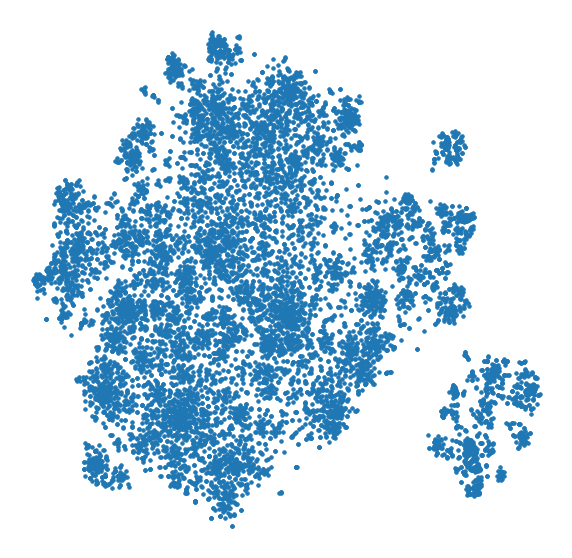

In [62]:
plt.figure(figsize=(10,10))
plt.scatter(embed_all[:].T[0], embed_all[:].T[1], s=12)
plt.axis('off')
plt.show()

In [63]:
# tsne_all_2 = TSNE(perplexity=25, n_iter=10000, init='pca')

In [64]:
# embed_all_2 = tsne_all.fit_transform(df_tsne.loc[:,'minplayers':])

In [65]:
# embed_all_2 = pd.to_pickle(embed_all_2, 'data/tsne2')
embed_all_2 = pd.read_pickle('data/tsne2')

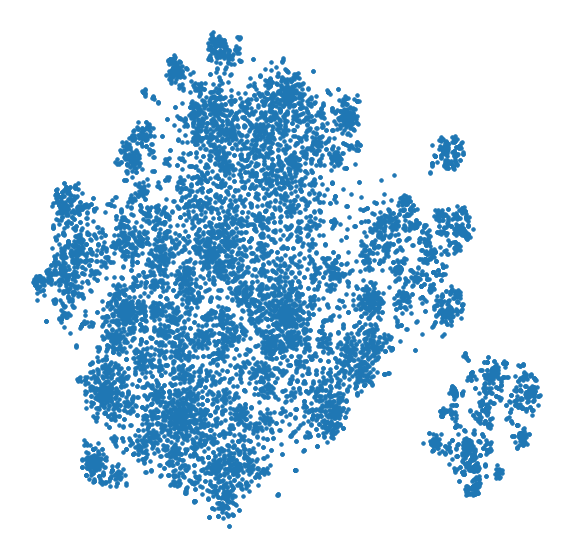

In [66]:
plt.figure(figsize=(10,10))
plt.scatter(embed_all_2[:].T[0], embed_all_2[:].T[1], s=12)
plt.axis('off')
plt.show()

In [67]:
# These t-SNE's take awhile to run and they're fairly messy to look at but that's only because they're using all our data points
# As we've included a load of games that never really made it's natural to reduce our data to only include popular games
# With that in mind we move to using only the top 2000 games in our dataframe

In [68]:
df_tsne_top = df_tsne.sort_values(by='bayes_average_rating', ascending=False)[:2000]
df_tsne_top.shape

(2000, 141)

In [69]:
# tsne_top = TSNE(perplexity=30, init='pca', n_iter=8000)

In [70]:
# embed_top = tsne_top.fit_transform(df_tsne_top.loc[:,'minplayers':])

In [71]:
# embed_top = pd.to_pickle(embed_top, 'data/tsne3')
embed_top = pd.read_pickle('data/tsne3')

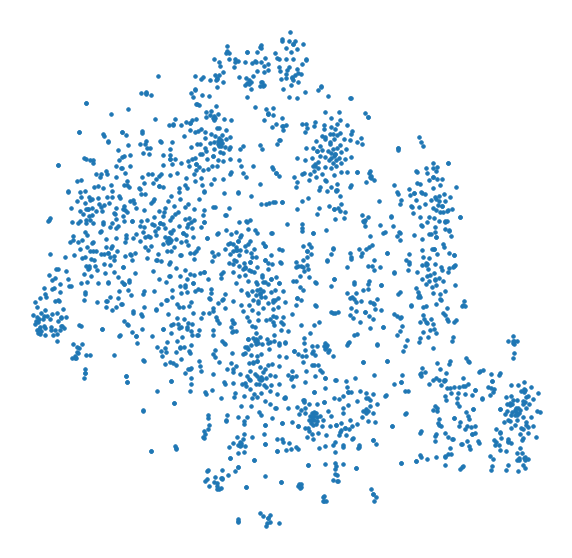

In [72]:
plt.figure(figsize=(10,10))
plt.scatter(embed_top[:].T[0], embed_top[:].T[1], s=12)
plt.axis('off')
plt.show()

## Clustering

In [73]:
clusterer_top = hdbscan.HDBSCAN(min_cluster_size=8, min_samples=5)

In [74]:
clusterer_top.fit(embed_top)

HDBSCAN(algorithm='best', allow_single_cluster=False, alpha=1.0,
        approx_min_span_tree=True, cluster_selection_epsilon=0.0,
        cluster_selection_method='eom', core_dist_n_jobs=4,
        gen_min_span_tree=False, leaf_size=40,
        match_reference_implementation=False, memory=Memory(location=None),
        metric='euclidean', min_cluster_size=8, min_samples=5, p=None,
        prediction_data=False)

In [75]:
clusterer_top.labels_.max()+2

38

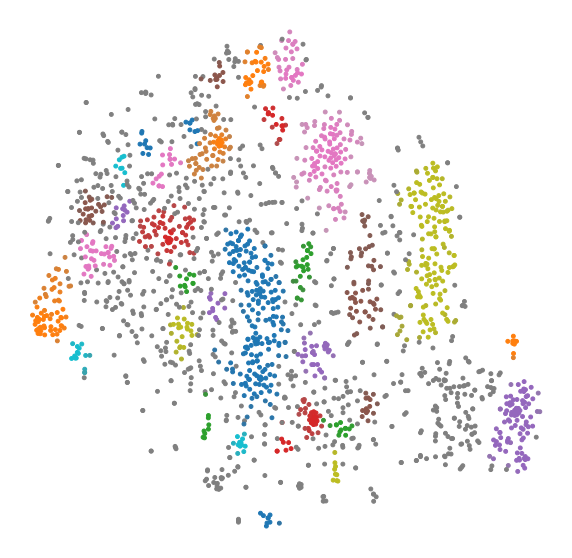

In [76]:
palette = sns.color_palette(n_colors=len(clusterer_top.labels_))

cluster_colors = [sns.desaturate(palette[col], sat)
                  if col >= 0 else (0.5, 0.5, 0.5) 
                  for col, sat in zip(clusterer_top.labels_, clusterer_top.probabilities_)]

plt.figure(figsize=(10,10))
plt.scatter(embed_top[:].T[0], embed_top[:].T[1], c=cluster_colors, s = 15)
plt.axis('off')
plt.show()

In [77]:
clusterer_top_2 = hdbscan.HDBSCAN(min_cluster_size=8, min_samples=4)

In [78]:
clusterer_top_2.fit(embed_top)

HDBSCAN(algorithm='best', allow_single_cluster=False, alpha=1.0,
        approx_min_span_tree=True, cluster_selection_epsilon=0.0,
        cluster_selection_method='eom', core_dist_n_jobs=4,
        gen_min_span_tree=False, leaf_size=40,
        match_reference_implementation=False, memory=Memory(location=None),
        metric='euclidean', min_cluster_size=8, min_samples=4, p=None,
        prediction_data=False)

In [79]:
clusterer_top_2.labels_.max()+2

41

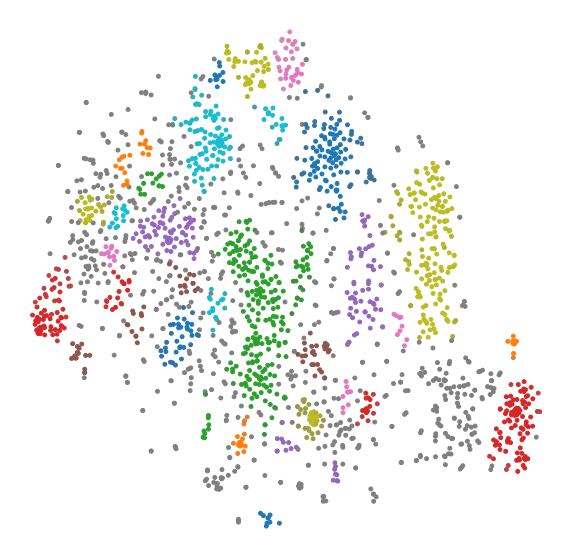

In [80]:
palette = sns.color_palette(n_colors=len(clusterer_top_2.labels_))

cluster_colors_2 = [sns.desaturate(palette[col], sat)
                  if col >= 0 else (0.5, 0.5, 0.5) 
                  for col, sat in zip(clusterer_top_2.labels_, clusterer_top_2.probabilities_)]

plt.figure(figsize=(10,10))
plt.scatter(embed_top[:].T[0], embed_top[:].T[1], c=cluster_colors_2, s = 15)
plt.axis('off')
plt.show()

We'll now produce a dataframe to store our cluster labels. This is what we'll use in producing a linked graph of clusters.

In [81]:
# Adding three as we need to go up to the last label

name_lst = df_tsne_top['details.name']

top_labels = list(zip(name_lst, clusterer_top_2.labels_+2))

cluster_dict_final = {}

for label in range(1, clusterer_top_2.labels_.max() + 3):
    namelst = []
    for name, cat in top_labels:
        if cat == label:
            namelst.append(name)
    cluster_dict_final[label] = namelst

In [82]:
df_labels = pd.DataFrame(data={'name': name_lst, 'label': clusterer_top_2.labels_+2, 'x':embed_top[:].T[0],
                                  'y':embed_top[:].T[1], 'local_labels':[[] for i in range(len(embed_top))]})

df_labels = df_labels.loc[df_labels['label'] != 1]
df_labels.head()

,name,label,x,y,local_labels
11078,Gloomhaven,10,66.266998,20.767550,[]
10554,Pandemic Legacy: Season 1,6,34.336460,15.337066,[]
11435,Through the Ages: A New Story of Civilization,17,-46.602711,-6.157127,[]
4313,Twilight Struggle,9,64.634544,-32.793552,[]
11592,Star Wars: Rebellion,9,60.201328,-20.831413,[]


In [83]:
# # Commented out as this takes ages to run

# for label in set(df_labels['label']):
#     for index, row in df_labels.loc[df_labels['label'] == label].iterrows():
#         x = df_labels.loc[index, 'x']
#         y = df_labels.loc[index, 'y']
#         for index_2, row_2 in df_labels.loc[df_labels['label'] != label].iterrows():
#             other_label = df_labels.loc[df_labels['label'] != label].loc[index_2, 'label']
#             x_other = df_labels.loc[index_2, 'x']
#             y_other = df_labels.loc[index_2, 'y']
#             if (x - x_other)**2 + (y - y_other)**2 <= 9:
#                 df_labels.loc[index, 'local_labels'].append(other_label)

In [84]:
# df_labels = pd.to_pickle(df_labels, 'data/labels1')
df_labels = pd.read_pickle('data/labels1')

In [85]:
df_labels.head()

,name,label,x,y,local_labels
11078,Gloomhaven,13,55.132168,7.293947,[]
11592,Star Wars: Rebellion,9,45.387768,-30.116642,[]
7922,The Castles of Burgundy,10,-1.736828,-49.171669,[]
11039,7 Wonders Duel,35,-32.189522,32.810043,[]
11334,The 7th Continent,7,20.669128,16.579557,[]


In [86]:
connected_labels_lst = list(set(df_labels[df_labels['local_labels'].map(lambda d: len(d)) > 0]['label']))

In [87]:
df_connected_labels = df_labels[df_labels['local_labels'].map(lambda d: len(d)) > 0]
df_connected_labels.head()

,name,label,x,y,local_labels
11474,Grand Austria Hotel,46,-51.529869,-0.533879,"[45, 45, 45]"
6816,At the Gates of Loyang,45,-53.931103,-0.089974,"[46, 46]"
10531,Stockpile,43,-55.991379,8.354721,[44]
6895,Finca,45,-53.904186,-1.126638,"[46, 46]"
9784,Scoville,42,-43.730431,8.631577,[37]


In [88]:
# List of edges with their weights

label_edges = []

for lbl in range(2, clusterer_top_2.labels_.max() + 3):
    local_lst = []
    for index, row in df_connected_labels.loc[df_connected_labels['label'] == lbl].iterrows():
        local_lst.append(row['local_labels'])
    local_lst = [item for sublist in local_lst for item in sublist]
    for cnct in set(local_lst):
        label_edges.append((lbl, cnct, {'weight' : round(local_lst.count(cnct)/len(local_lst),3)}))

In [89]:
label_edges

[(8, 9, {'weight': 1.0}),
 (9, 8, {'weight': 1.0}),
 (10, 11, {'weight': 1.0}),
 (11, 10, {'weight': 1.0}),
 (21, 22, {'weight': 1.0}),
 (22, 21, {'weight': 1.0}),
 (24, 39, {'weight': 1.0}),
 (25, 26, {'weight': 1.0}),
 (26, 25, {'weight': 1.0}),
 (28, 30, {'weight': 1.0}),
 (29, 32, {'weight': 1.0}),
 (30, 28, {'weight': 1.0}),
 (31, 32, {'weight': 1.0}),
 (32, 29, {'weight': 0.667}),
 (32, 31, {'weight': 0.333}),
 (35, 39, {'weight': 1.0}),
 (37, 42, {'weight': 1.0}),
 (38, 39, {'weight': 1.0}),
 (39, 24, {'weight': 0.333}),
 (39, 35, {'weight': 0.333}),
 (39, 38, {'weight': 0.333}),
 (40, 41, {'weight': 1.0}),
 (41, 40, {'weight': 1.0})]

In [90]:
G = nx.Graph()

In [91]:
G.add_nodes_from(range(2, clusterer_top_2.labels_.max() + 3))

In [92]:
G.add_edges_from(label_edges)

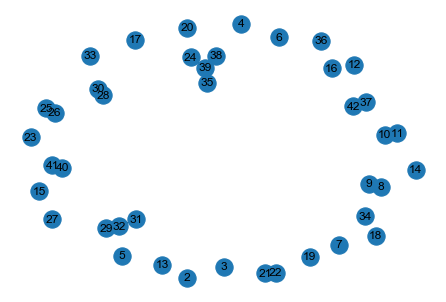

In [94]:
nx.draw(G, with_labels=True)
plt.axis('off')
plt.show()

We've ended up with a weighted graph with only a few connections, not very interesting! We'll now move over to using a refactored version so that we can quickly step through the proccess. The method will be identical but all of the raw code will be tidied away into a class.

## Finding the best graph

In [95]:
from library import *

In [96]:
# Let's look at the top 1000 most popular games
# Popular games sell well, they should contain market insight

df_tsne_top_1000 = df_tsne.sort_values(by='bayes_average_rating', ascending=False)[:1000]

In [97]:
# We create an instance of our BGG class
# This will create an embedding of the dataframe with standard t-SNE parameters (perplexity = 50 etc..,)

test_1 = BGG(df_tsne_top_1000, perp=45, n_iter=8000)

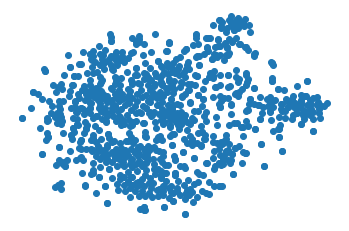

In [98]:
test_1.plot()

In [99]:
test_1.clusterer(min_cluster_size=6, min_samples=1)
len(test_1.cluster_dict)

50

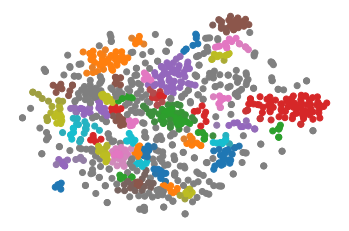

In [100]:
test_1.plot(clusters=True)

In [102]:
test_1.graph_data()

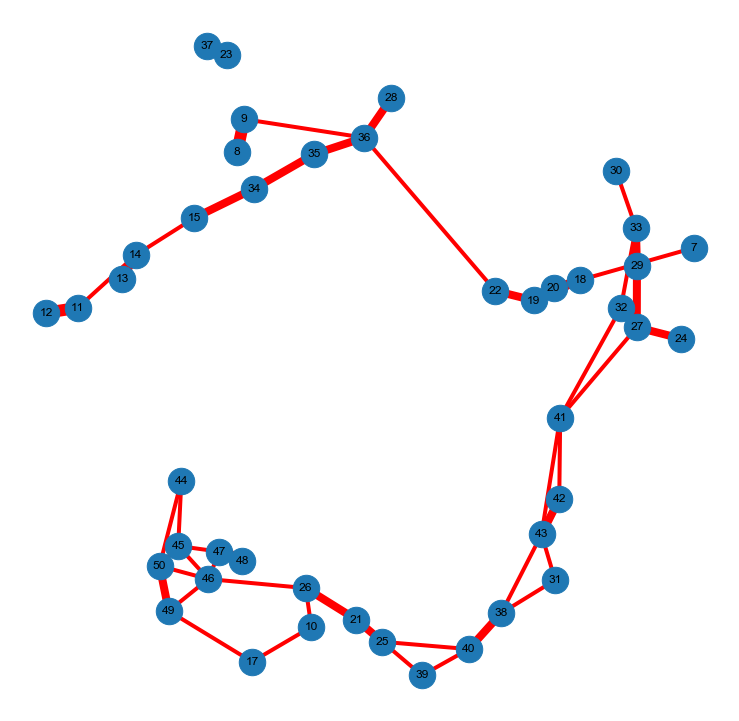

In [249]:
plt.figure(figsize=(13,13)).patch.set_alpha(0)
test_1.draw_graph()

In [104]:
test_2 = BGG(df_tsne_top_1000, perp=25, n_iter=8000)

In [150]:
test_2.tsne.n_iter_

5349

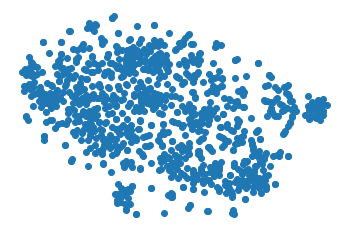

In [105]:
test_2.plot()

In [172]:
test_2.clusterer(min_cluster_size=7, min_samples=1)
len(test_2.cluster_dict)

44

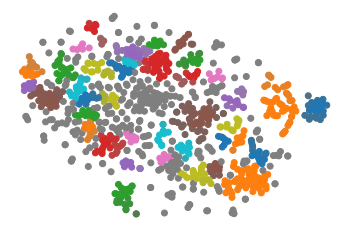

In [173]:
test_2.plot(clusters=True)

In [174]:
test_2.graph_data()

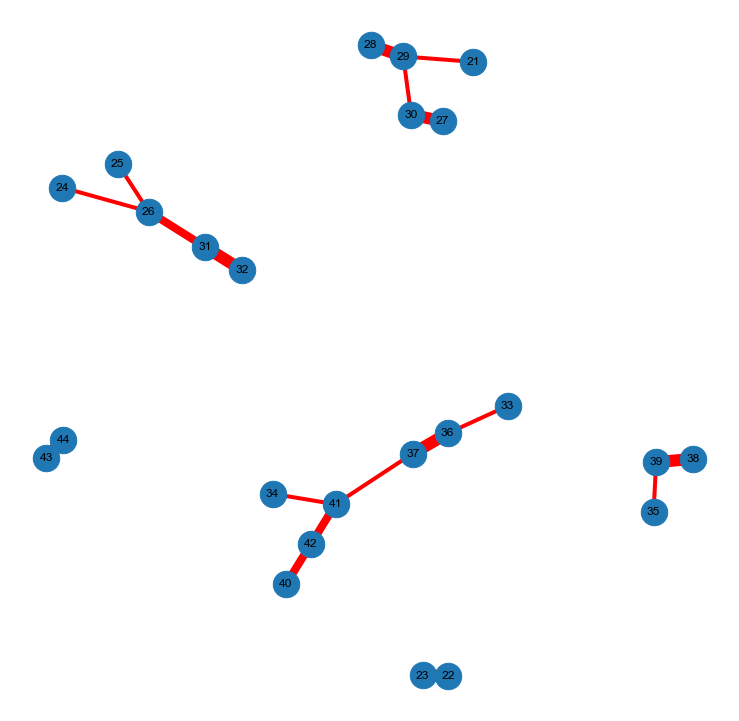

In [208]:
plt.figure(figsize=(13,13)).patch.set_alpha(0)
test_2.draw_graph()

In [209]:
test_2.cluster_dict[22], test_2.cluster_dict[23]

(['Star Wars: Imperial Assault',
  'Xia: Legends of a Drift System',
  'Neuroshima Hex!',
  'Space Hulk (third edition)',
  'Earth Reborn',
  'Gears of War: The Board Game',
  'Specter Ops',
  'Star Trek: Fleet Captains',
  'Space Hulk',
  'Space Hulk (fourth edition)',
  'Level 7 [Omega Protocol]',
  'BattleTech',
  'Doom: The Boardgame',
  'Galaxy Defenders',
  'Necromunda',
  'Space Crusade',
  'Ogre'],
 ['Gloomhaven',
  'Mage Knight Board Game',
  'Kingdom Death: Monster',
  'Mechs vs. Minions',
  'Robinson Crusoe: Adventures on the Cursed Island',
  'Eldritch Horror',
  'T.I.M.E Stories',
  'Descent: Journeys in the Dark (Second Edition)',
  'Chaos in the Old World',
  'Arcadia Quest',
  'Zombicide: Black Plague',
  'Runewars',
  'Small World',
  'Cthulhu Wars',
  'Ghost Stories',
  'Claustrophobia',
  'Mice and Mystics',
  'Arkham Horror',
  'Heroscape Master Set: Rise of the Valkyrie',
  'Shadows of Brimstone: City of the Ancients',
  'Descent: Journeys in the Dark',
  'Sword & 

In [110]:
test_3 = BGG(df_tsne_top_1000, perp=5, n_iter=8000)

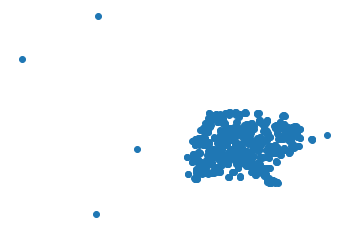

In [111]:
test_3.plot()

In [112]:
test_3.clusterer(min_cluster_size=6, min_samples=1)
len(test_3.cluster_dict)

73

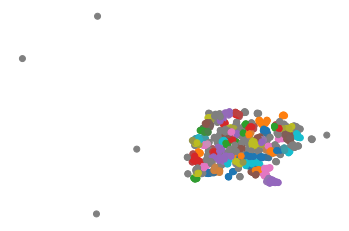

In [113]:
test_3.plot(clusters=True)

In [135]:
test_3.graph_data(cluster_dist=5)

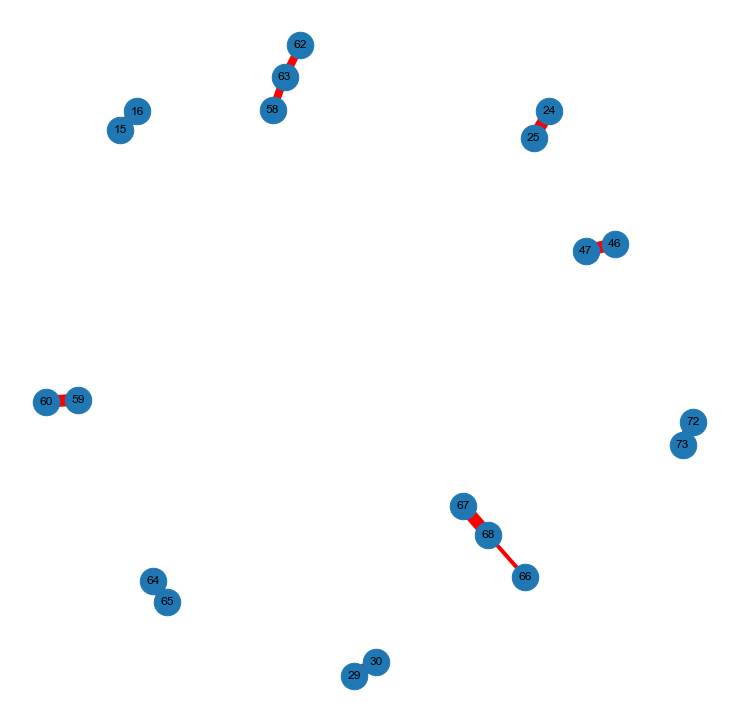

In [584]:
plt.figure(figsize=(13,13)).patch.set_alpha(0)
test_3.draw_graph()

In [119]:
test_4 = BGG(df_tsne_top_1000, perp=200, n_iter=8000)

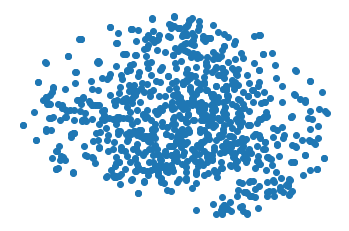

In [120]:
test_4.plot()

In [148]:
test_4.clusterer(min_cluster_size=7, min_samples=2)
len(test_4.cluster_dict)

45

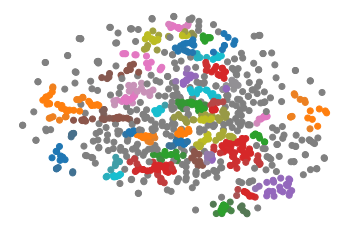

In [149]:
test_4.plot(clusters=True)

In [123]:
test_4.graph_data()

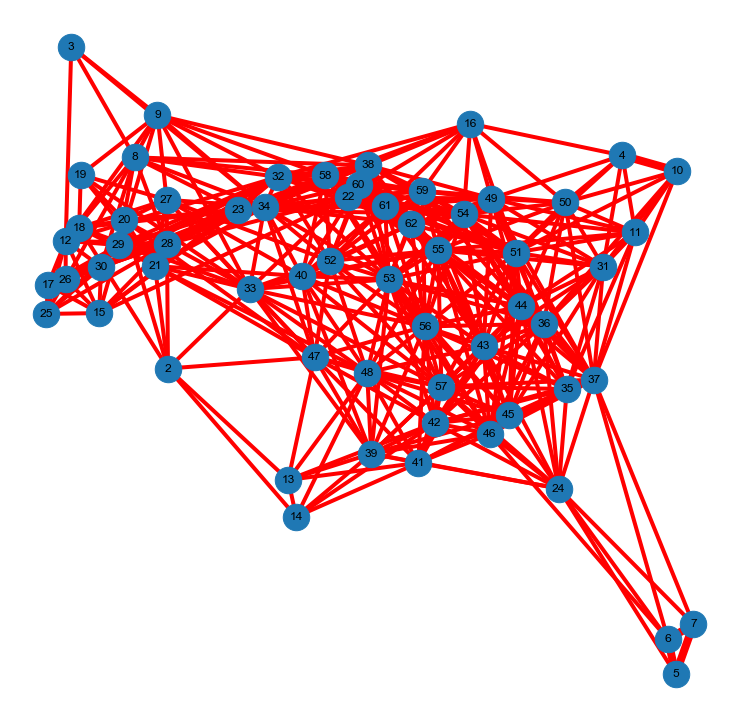

In [581]:
plt.figure(figsize=(13,13)).patch.set_alpha(0)
test_4.draw_graph()

In [125]:
test_5 = BGG(df_tsne_top_1000, perp=400, n_iter=8000)

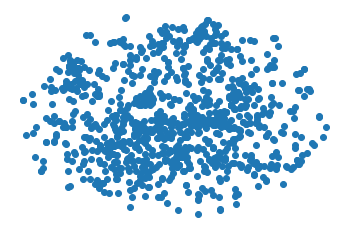

In [126]:
test_5.plot()

In [195]:
test_5.clusterer(min_cluster_size=6, min_samples=4)
len(test_5.cluster_dict)

40

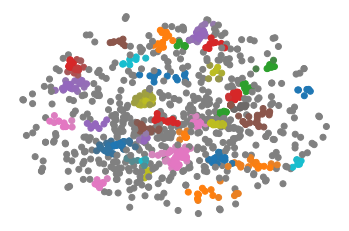

In [196]:
test_5.plot(clusters=True)

In [197]:
test_5.graph_data()

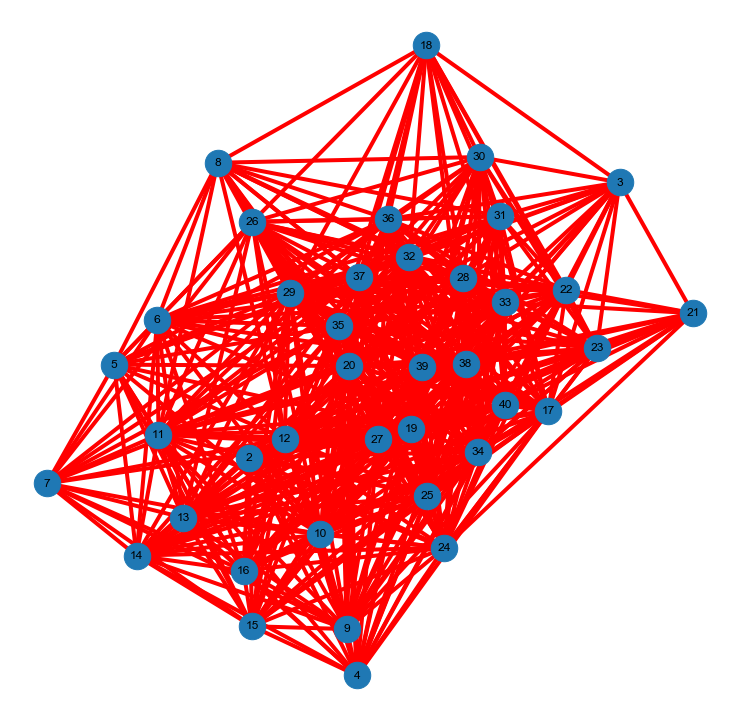

In [440]:
plt.figure(figsize=(13,13)).patch.set_alpha(0)
test_5.draw_graph()

In [101]:
test_6 = BGG(df_tsne_top_1000, perp=35, n_iter=8000)

In [102]:
test_6.tsne.n_iter_

4949

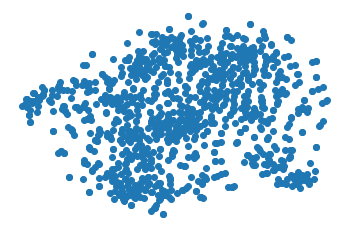

In [103]:
test_6.plot()

In [104]:
test_6.clusterer(min_cluster_size=6, min_samples=1)
len(test_6.cluster_dict)

50

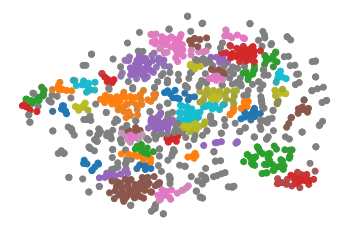

In [105]:
test_6.plot(clusters=True)

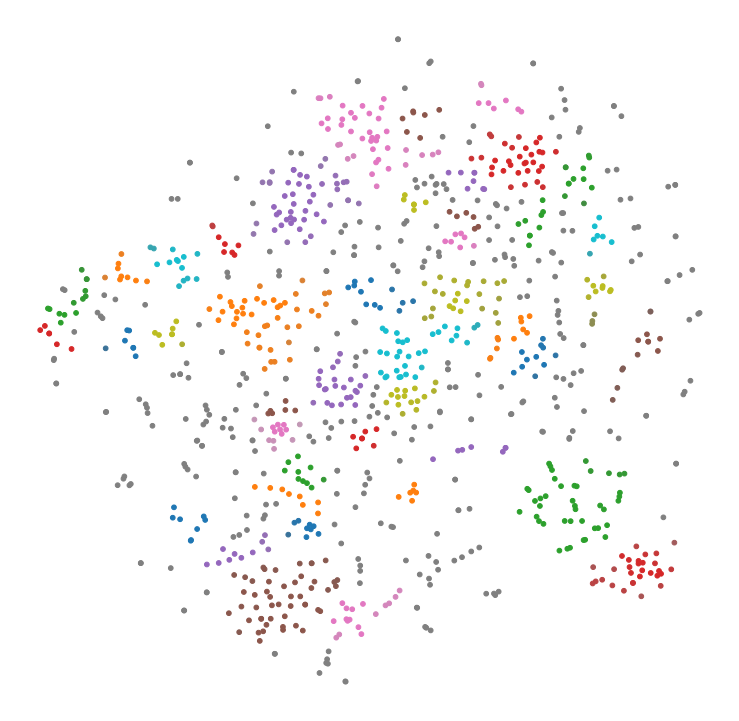

In [106]:
plt.figure(figsize=(13,13)).patch.set_alpha(0)
palette_tst_6 = sns.color_palette(n_colors=len(test_6.clusters.labels_))

cluster_colors_tst_6 = [sns.desaturate(palette[col], sat) if col >= 0 else (0.5, 0.5, 0.5) for col, sat in zip(test_6.clusters.labels_,
                                                                                                               test_6.clusters.probabilities_)]

plt.scatter(test_6.embed[:].T[0], test_6.embed[:].T[1], c=cluster_colors_tst_6, s = 22)

plt.axis('off')
plt.show()

In [107]:
test_6.graph_data()

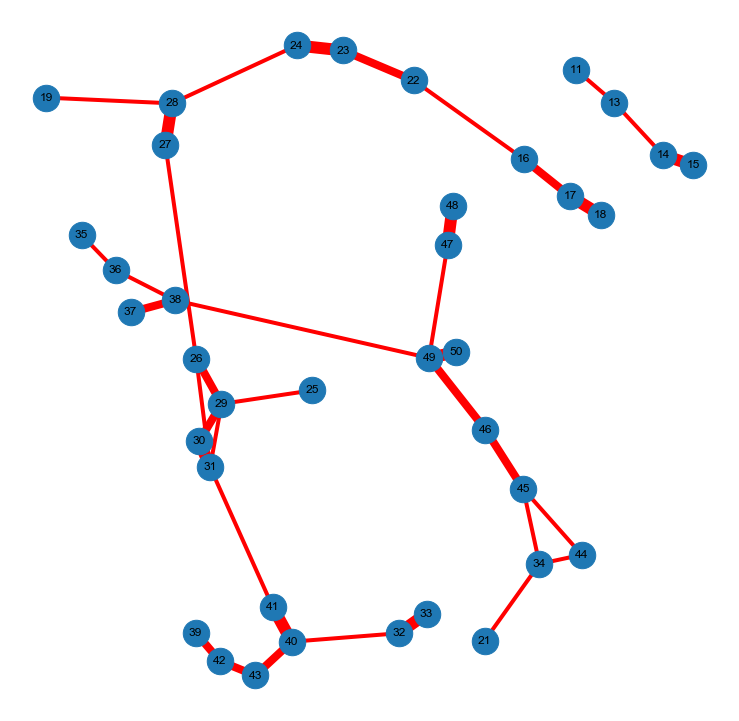

In [433]:
plt.figure(figsize=(13,13)).patch.set_alpha(0)
test_6.draw_graph()

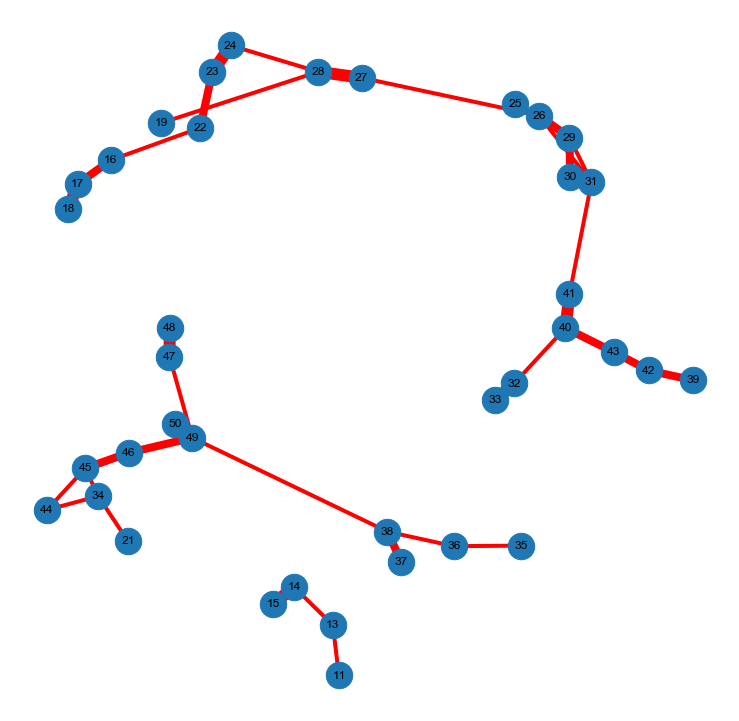

In [438]:
plt.figure(figsize=(13,13)).patch.set_alpha(0)
test_6.draw_graph()

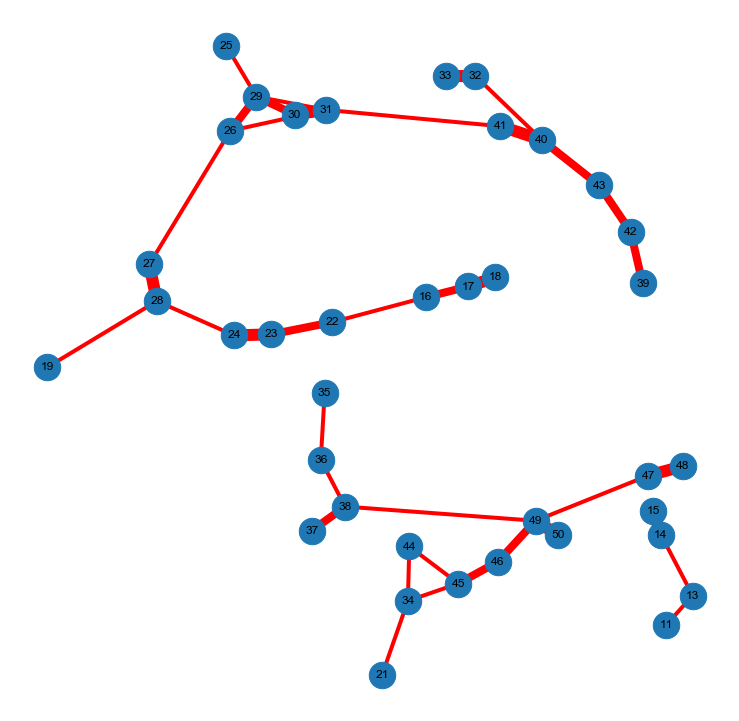

In [410]:
plt.figure(figsize=(13,13)).patch.set_alpha(0)
test_6.draw_graph()

In [357]:
test_6.cluster_dict[15], test_6.cluster_dict[14], test_6.cluster_dict[13], test_6.cluster_dict[11]

(['One Night Ultimate Werewolf',
  'One Night Ultimate Werewolf Daybreak',
  'BANG! The Dice Game',
  'Shadow Hunters',
  'Ultimate Werewolf: Ultimate Edition',
  "The Werewolves of Miller's Hollow"],
 ['The Resistance: Avalon',
  'Deception: Murder in Hong Kong',
  'The Resistance',
  "Time's Up! Title Recall!",
  'Monikers',
  "Time's Up!",
  'Spyfall',
  'Concept',
  'When I Dream',
  'Two Rooms and a Boom',
  'Insider',
  'Spyfall 2',
  'Imagine'],
 ['Telestrations',
  'Telestrations: 12 Player Party Pack',
  'Wits & Wagers',
  'Pictomania',
  'Loony Quest',
  'Fauna',
  'Eat Poop You Cat',
  'Escape from the Aliens in Outer Space',
  'Say Anything'],
 ['Crokinole',
  'PitchCar',
  'Junk Art',
  "Flick 'em Up!",
  'Rhino Hero',
  'Ice Cool',
  "Loopin' Louie",
  'Animal Upon Animal',
  'Coconuts',
  'Spot it!',
  'Ghost Blitz',
  'Bausack',
  'Happy Salmon',
  'Gulo Gulo'])

In [583]:
df_tsne_top_1000.loc[df_tsne_top_1000['details.name'].isin(test_6.cluster_dict[11])].sort_values(by='bayes_average_rating', ascending=False).head(3)

,id,details.name,minplayers,maxplayers,playingtime,bayes_average_rating,average_weight,Spies/Secret Agents,Word Game,Civil War,Novel-based,Ancient,Pirates,Space Exploration,Mafia,Political,Animals,American Indian Wars,Trains,Number,Real-time,Korean War,Electronic,Aviation / Flight,Zombies,Video Game Theme,Puzzle,City Building,Vietnam War,Medieval,Environmental,Fantasy,Medical,Mature / Adult,Deduction,Children's Game,Educational,Napoleonic,Dice,Modern Warfare,Negotiation,None,Farming,Math,Expansion for Base-game,Horror,Miniatures,Movies / TV / Radio theme,Card Game,Racing,Post-Napoleonic,Nautical,World War II,Collectible Components,Game System,Book,Economic,World War I,Prehistoric,Civilization,Murder/Mystery,Trivia,Bluffing,Abstract Strategy,Age of Reason,Action / Dexterity,American West,Exploration,Adventure,Fighting,Renaissance,Industry / Manufacturing,Comic Book / Strip,American Revolutionary War,Wargame,Music,Print & Play,Humor,Transportation,Religious,Party Game,Travel,Memory,Territory Building,Arabian,Maze,Science Fiction,Sports,Pike and Shot,American Civil War,Mythology,Action / Movement Programming,Secret Unit Deployment,Stock Holding,Campaign / Battle Card Driven,Point to Point Movement,Area Control / Area Influence,Voting,Time Track,Card Drafting,Player Elimination,Press Your Luck,Auction/Bidding,Role Playing,Pattern Recognition,Area Movement,Tile Placement,Dice Rolling,Action Point Allowance System,Modular Board,Variable Player Powers,Hand Management,Deck / Pool Building,Take That,Storytelling,Crayon Rail System,Worker Placement,Hex-and-Counter,Acting,Trick-taking,Chit-Pull System,Singing,Pick-up and Deliver,Area Enclosure,Commodity Speculation,Roll / Spin and Move,Co-operative Play,Line Drawing,Area-Impulse,Route/Network Building,Rock-Paper-Scissors,Grid Movement,Pattern Building,Betting/Wagering,Variable Phase Order,Partnerships,Paper-and-Pencil,Simulation,Trading,Simultaneous Action Selection,Set Collection
389,521.0,Crokinole,0.111111,0.333333,0.060543,0.800681,0.25282,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
120,150.0,PitchCar,0.111111,0.777778,0.060543,0.689972,0.22574,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
11757,193042.0,Junk Art,0.111111,0.555556,0.060543,0.684297,0.25284,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [218]:
df_tsne_top.shape

(2000, 141)

In [219]:
test_7 = BGG(df_tsne_top, perp= 30, n_iter=8000)

In [319]:
test_7.tsne.n_iter_

6249

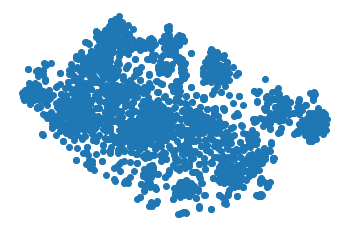

In [220]:
test_7.plot()

In [310]:
test_7.clusterer(min_cluster_size = 8, min_samples = 5)
len(test_7.cluster_dict)

38

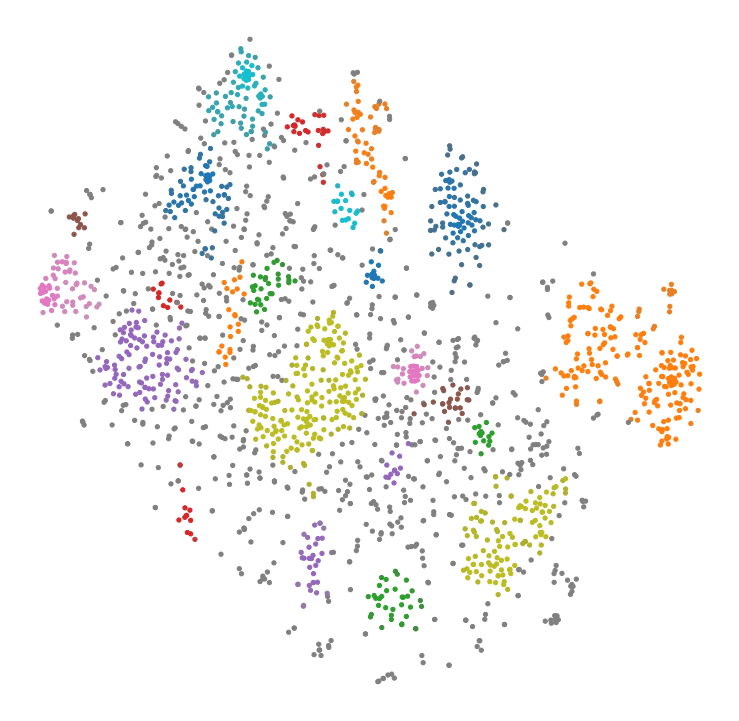

In [582]:
plt.figure(figsize=(13,13))
palette_tst = sns.color_palette(n_colors=len(test_7.clusters.labels_))

cluster_colors_tst = [sns.desaturate(palette[col], sat) if col >= 0 else (0.5, 0.5, 0.5) for col, sat in zip(test_7.clusters.labels_, test_7.clusters.probabilities_)]

plt.scatter(test_7.embed[:].T[0], test_7.embed[:].T[1], c=cluster_colors_tst, s = 18)

plt.axis('off')
plt.show()

In [242]:
test_7.graph_data(cluster_dist=5)

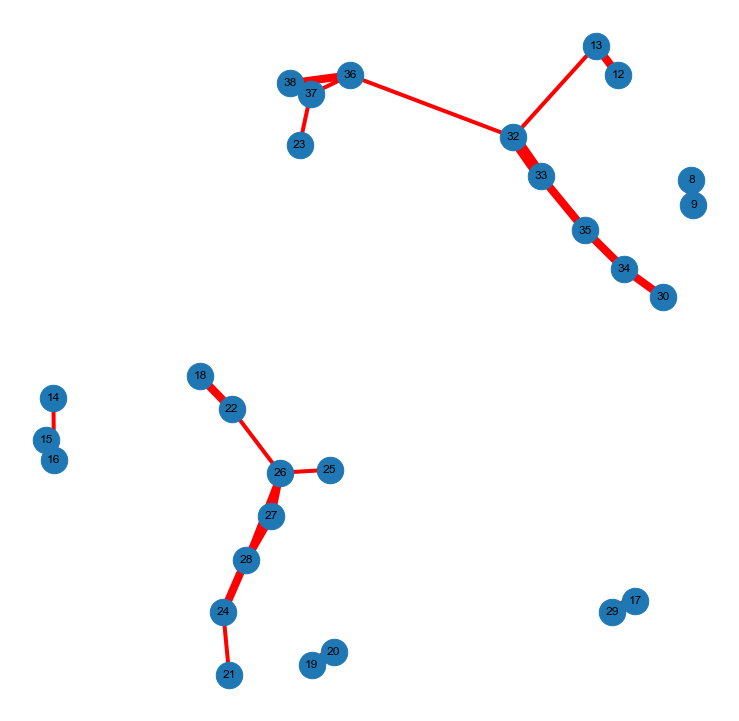

In [245]:
plt.figure(figsize=(13,13)).patch.set_alpha(0)
test_7.draw_graph()

In [246]:
test_7_2 = test_7

In [349]:
test_7_2.graph_data(cluster_dist=7)

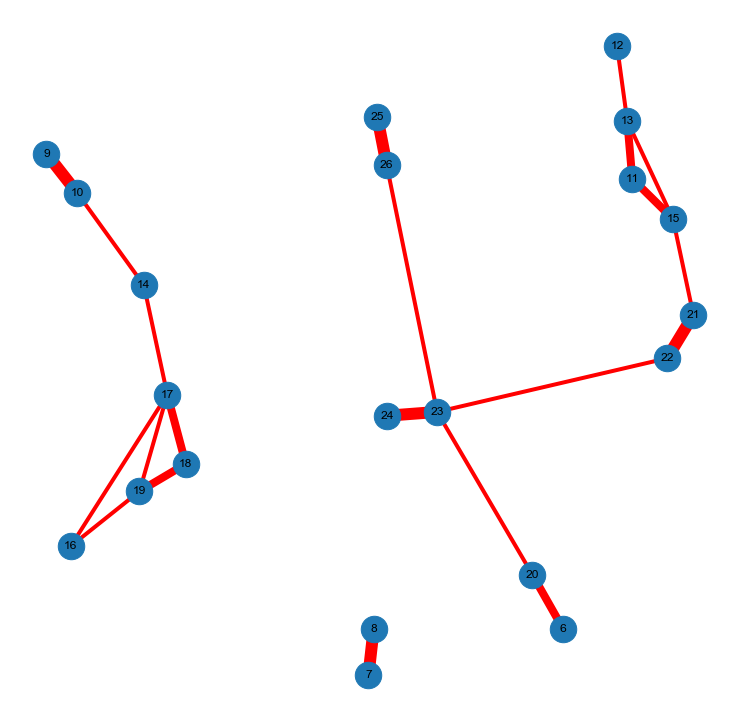

In [350]:
plt.figure(figsize=(13,13)).patch.set_alpha(0)
test_7_2.draw_graph()

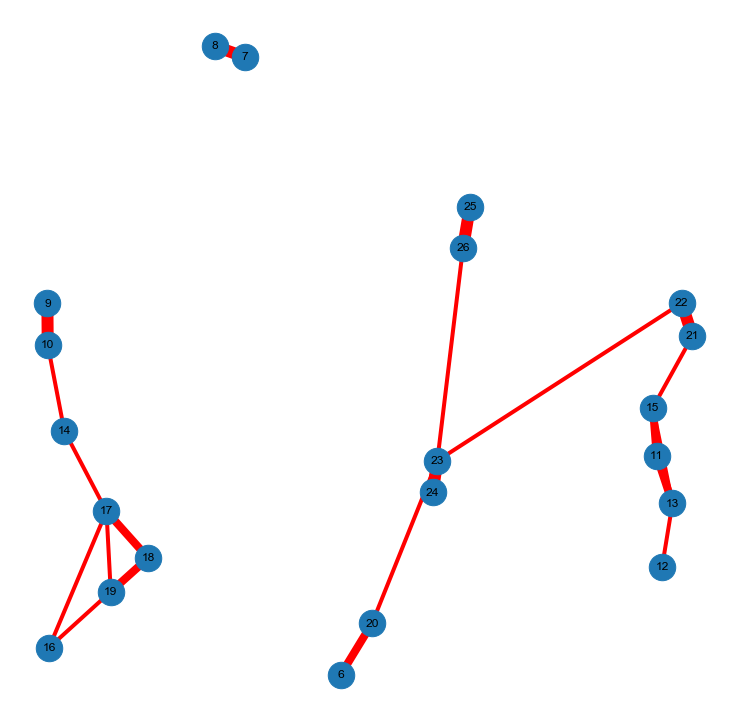

In [353]:
plt.figure(figsize=(13,13)).patch.set_alpha(0)
test_7_2.draw_graph()